# Project: SkimLit


The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we are replicating(the source of the dataset that we will be using) is available : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to acheive their best results is available here: https://aclanthology.org/E17-2110/



## Confirm access to a GPU

In [1]:
## Check for GPU
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get data

Since we will be replicating the paper above(PubMed 200k RCT). Let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [4]:
# check what files are in the PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by @ sign.
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess the data

Now we have some text data, it is time to become one with it. And one of the best ways to become one with the data is to visualize it.

So with that in mind, let's create a function to read in all the lines of a target text file.


In [7]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads file name (a text file name) and returns the lines of the text file as a list

    Args:
    filename: a string containing the target filepath.
    Returns:
    A list of string with one string per line from the target filename.
    """
    with open(filename,"r") as f:
        return f.readlines()

In [8]:
# Let's read in the training files
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

```[{'line_number':0,
    'target':'BACKGROUND',
    'text':'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines':11}]```

In [10]:
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
test_list = []
info_dict = dict()
for index,i in enumerate(train_lines[:27]):

    split_text = i.splitlines()


    for j in split_text:

        line_split = j.split('\t')

        if len(line_split) > 1:
            if line_split[0] not in info_dict:
                info_dict[line_split[0]] = line_split[1]
            else:
                info_dict[line_split[0]] = info_dict[line_split[0]] + line_split[1]
        # print(info_dict)
        if "###" in j:
            info_dict["id"] = j.split('###')[1]

        if j == '':

            test_list.append(info_dict)
            info_dict = dict()
            print("===============================")
print(test_list)
print(len(test_list))

[{'id': '24293578', 'OBJECTIVE': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'METHODS': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .Pain was assessed using the visual analog pain scale ( @-@ mm ) .Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .'

In [12]:
def preprocess_text_with_line_number(filename):
    """
    Returns a list of dictionaries of abstract lines of data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number the target line is
    """
    input_lines = get_lines(filename)
    abstract_lines = "" #create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    #loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): #check to see if it starts with a ID line
            abstract_id = line
            abstract_lines = "" #reset the abstract string if the line is a 1D line
        elif line.isspace(): #check if the line is a new line
            abstract_line_split = abstract_lines.splitlines() #split abstract into seperate lines

            #iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") #split target label from text
                line_data["target"] = target_text_split[0] #get target label
                line_data["text"] = target_text_split[1].lower() #get target text and lower the text
                line_data["line_number"] = abstract_line_number #what number line does the line appear in abstract
                line_data["total_lines"] = len(abstract_line_split) - 1 # How many total lines are there in the abstract
                abstract_samples.append(line_data)#add line data to abstract sample
        else: #if the above conditions are not fulfilled, the line containins a labelled sentence
            abstract_lines += line

    return abstract_samples

In [13]:
# Get data from file and process it
%time
train_samples = preprocess_text_with_line_number(data_dir + "train.txt")
val_samples = preprocess_text_with_line_number(data_dir+"dev.txt") #dev is another name for validation
test_samples = preprocess_text_with_line_number(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


(180040, 30212, 30135)

In [14]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the form of list of dictionaries, how about we turn it into a dataframe to further visualize it.

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
# distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

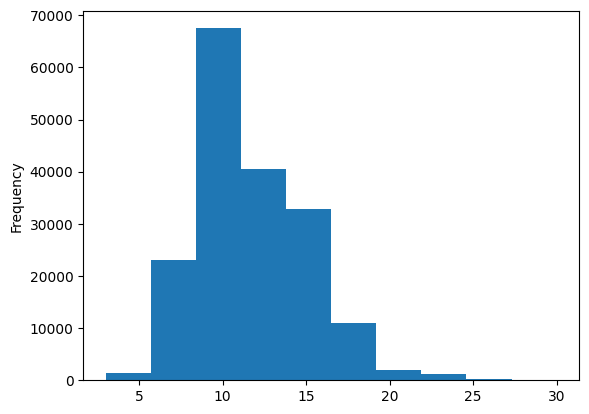

In [17]:
# Let's check the length if differrent lines
train_df.total_lines.plot(kind="hist");

### GET list of sentences

In [18]:
#convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# view the 10 lines of train_sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels(ML models require numeric labels)


In [20]:
# One hot encode labels
import numpy as np
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(np.expand_dims(train_df["target"].to_numpy(), axis=1))
val_labels_one_hot = one_hot_encoder.transform(np.expand_dims(val_df["target"].to_numpy(), axis=1))
test_labels_one_hot = one_hot_encoder.transform(np.expand_dims(test_df.target.to_numpy(), axis=1))
#check what one hot encoded label looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [21]:
# Extract labels(target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#check out the label encoded train labels
train_labels_encoded, val_labels_encoded, test_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 0, 3, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]))

In [22]:
# Get the class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline model

Starting a series of modelling experiments. Let's try a bunch of differrent models and see which one works best. We are going to start a baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [23]:
#creating a tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("TFIDF",TfidfVectorizer()),
    ("NB",MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)


Pipeline(steps=[('TFIDF', TfidfVectorizer()), ('NB', MultinomialNB())])

In [24]:
#evaluating the model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
!wget "https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py"

--2024-04-27 14:12:04--  https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10128 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2024-04-27 14:12:04 (95.5 MB/s) - ‘helper_functions.py’ saved [10128/10128]



In [27]:
#importing the calculate results from the helper functions
from helper_functions import calculate_results

base_line_results = calculate_results(val_labels_encoded, baseline_preds)
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepairing our data for deep sequence models

Before we start building deeper models, we have to create vectorization and embedding layers.


In [28]:
#finding the max vocab length
sum([len(i.split()) for i in train_sentences])

4741942

In [29]:
#How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [30]:
#finding the max length
round(sum(len(i.split()) for i in train_sentences)/len(train_sentences))

26

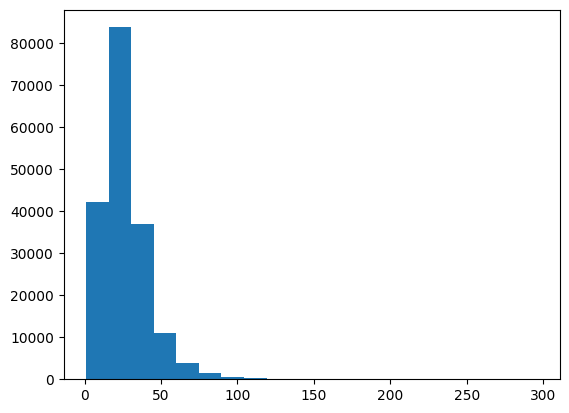

In [31]:
# What does the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [32]:
# How long of a sentence length covers 95% of example?
output_seq_length = np.percentile(sent_lens, 95)
output_seq_length

55.0

In [33]:
# Maximum sequence length in training set
max(sent_lens)

296

In [34]:
max_vocab_length = 4741942
max_length = 26

### Creating a text vectorizer layer

We want to make a layer which maps our texts from words to numbers

In [35]:
# How many words should be in the vocabulary (taken from table 2 under [V]
max_tokens=68000


In [36]:
from tensorflow.keras import layers

#creating a text vectorizer instance
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                           output_mode="int",
                                           output_sequence_length=int(output_seq_length),
                                           pad_to_max_tokens=True)


In [37]:
# fitting the text vectorizer with train sentence
text_vectorizer.adapt(train_sentences)

In [38]:
# checking if text vectorizer is working

sample_sentence = ["This is a sample sentence"]
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  23,   20,    8,  441, 9848,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [39]:
# Chscking out out on a random sample
import random

random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}")
print(f"\n Length of the text:{len(random_sentence)}")
print(f"\nVectorized text:{text_vectorizer([random_sentence])}")


Text:
vas score was significantly lower in the new-scope group as compared with the conventional-scope group : meansd , median ( range ) : @ , @ ( @-@ ) vs @ , @ ( @-@ , p = @ ) .

 Length of the text:173

Vectorized text:[[  522   101    10    39   105     5     2 51355    13    25    34     7
      2 60828    13  6778   193   283    44    14     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# How many words are in our traning vocabulary
rct_20_k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab:{len(rct_20_k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20_k_text_vocab[:5]}")
print(f"Least common words in the vocab{rct_20_k_text_vocab[-5:]}")

Number of words in the vocab:64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Creating a custom text embedding layer

In [42]:
# creating an embedding instance
token_embedding = layers.Embedding(
    input_dim=len(rct_20_k_text_vocab),
    input_shape=(int(output_seq_length),),#NOTE: differrent embedding sizes gives drastically differrent results
    output_dim=128,
    mask_zero=True,#use masking to handle variable sequence langths(save space)
    name="token_embedding",
)

In [43]:
#show an example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Vectorized text : \n {vectorized_sentence}\n")
embedded_text = token_embedding(vectorized_sentence)
print(f"Embedded text: \n {embedded_text}\n")
print(f"Embedded sentence shape :\n{embedded_text.shape}\n")

Sentence before vectorization:
 vas score was significantly lower in the new-scope group as compared with the conventional-scope group : meansd , median ( range ) : @ , @ ( @-@ ) vs @ , @ ( @-@ , p = @ ) .

Vectorized text : 
 [[  522   101    10    39   105     5     2 51355    13    25    34     7
      2 60828    13  6778   193   283    44    14     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded text: 
 [[[ 0.03545043  0.0490602  -0.03972743 ... -0.00846993  0.00726264
    0.03697223]
  [ 0.02797297 -0.01750653 -0.0279399  ...  0.03347873 -0.01616699
    0.02595333]
  [-0.01240792  0.04152429  0.01571763 ... -0.00211723 -0.02912365
    0.03758467]
  ...
  [ 0.04767409  0.03593013  0.04464607 ...  0.03467068 -0.00673847
   -0.01275442]
  [ 0.04767409  0.03593013  0.04464607 ...  0.03467068 -0.00673847
   -0.01

## Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two documents:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data


In [44]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))

valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [45]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
# Take the TensorSliceDataset's and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [47]:
#Creating a conv1d model

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) #vectorize text inputs
x = token_embedding(x) #create embedding
x = layers.Conv1D(64,kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x) #condense the output of feature vector from conv layer
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


In [48]:
#getting the model summary
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [49]:
#fitting the model
history_model_1 = model_1.fit(train_dataset,
                                steps_per_epoch = int(0.1 * len(train_dataset)), #only train on 10% of the batches
                                validation_data=valid_dataset,
                                epochs=3,
                                validation_steps = int(0.1 * len(valid_dataset)) #validate on 10% of validation batches
                             )

Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9244 - accuracy: 0.6321 - val_loss: 0.6932 - val_accuracy: 0.7347
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6582 - accuracy: 0.7552 - val_loss: 0.6332 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6141 - accuracy: 0.7741 - val_loss: 0.5953 - val_accuracy: 0.7862


In [50]:
#evaluating a model with full validation data
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5947 - accuracy: 0.7879


[0.5947392582893372, 0.7879319190979004]

In [51]:
# Make predictions (out model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.5271012e-01, 1.6401680e-01, 6.2744811e-02, 2.9222536e-01,
         2.8302861e-02],
        [4.2875049e-01, 3.0400294e-01, 1.4511732e-02, 2.4166146e-01,
         1.1073270e-02],
        [1.6357692e-01, 6.7679803e-03, 1.9085461e-03, 8.2768852e-01,
         5.8034009e-05],
        ...,
        [5.1437987e-06, 6.8534689e-04, 4.4102813e-04, 4.1530961e-06,
         9.9886429e-01],
        [5.2550588e-02, 4.8539302e-01, 9.7642049e-02, 6.7102447e-02,
         2.9731193e-01],
        [1.6240513e-01, 7.1753532e-01, 3.5793200e-02, 4.5272712e-02,
         3.8993642e-02]], dtype=float32),
 (30212, 5))

In [52]:
# finding the pred classes from pred probs
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [53]:
# Calculate results of model_1
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.79319475705017,
 'precision': 0.7847230716512823,
 'recall': 0.7879319475705018,
 'f1': 0.7853976704821627}

In [54]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embedding

Let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embedding, however we will be using USE.

In [55]:
# download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name="universal_sentence_encoder",
                                       )

In [56]:
# Test out the pretrained embedding on a random sentence
random_train_sentences = random.choice(train_sentences)
print(f"Random sentence : \n{random_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_sentence])
print(f"Sentence after embedding : \n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding : {len(use_embedded_sentence[0])}")


Random sentence : 
vas score was significantly lower in the new-scope group as compared with the conventional-scope group : meansd , median ( range ) : @ , @ ( @-@ ) vs @ , @ ( @-@ , p = @ ) .
Sentence after embedding : 
[-0.00793221 -0.06776516  0.0645308  -0.05806332  0.00284385 -0.03637723
  0.00753916 -0.06101619 -0.00175061  0.01549593  0.06084709  0.05930949
  0.02385647  0.00791887  0.04379078  0.0132109  -0.01091957  0.02129512
  0.05372187 -0.017726    0.04039107 -0.01320859 -0.03046518 -0.06449295
  0.00903737  0.05697035 -0.00355698  0.0742548  -0.06546989 -0.00773302]

Length of sentence embedding : 512


In [57]:
# creating the model
inputs = layers.Input(shape=(), dtype=tf.string, name="input_layer") # input layer
x = tf_hub_embedding_layer(inputs) # pass the inputs to the USE embedding layer
x = layers.Dense(128, activation="relu")(x) #adding an intermediate Dense layer
outputs = layers.Dense(5, activation="softmax", name="output_layer")(x) #output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_use_sentence_encoder")

#compiling the model
model_2.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer="adam")

In [58]:
#fitting the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              validation_data=valid_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), #training for 10% batches
                              validation_steps = int(0.1 * len(valid_dataset)))# validating for 10% of validation batches

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9145 - accuracy: 0.6524 - val_loss: 0.7961 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7672 - accuracy: 0.7035 - val_loss: 0.7547 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7503 - accuracy: 0.7130 - val_loss: 0.7378 - val_accuracy: 0.7081


In [59]:
#evaluating the model on full validation data
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7390 - accuracy: 0.7132


[0.7389694452285767, 0.7131603360176086]

In [60]:
# making prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:5]

945/945 [==============================] - 11s 11ms/step


array([[0.41854456, 0.36702278, 0.00272358, 0.2031847 , 0.00852432],
       [0.35792744, 0.5201075 , 0.00385133, 0.11603546, 0.00207824],
       [0.20027542, 0.13549171, 0.01982315, 0.6057987 , 0.03861094],
       [0.01284359, 0.05349875, 0.81048447, 0.00945736, 0.11371581],
       [0.03005935, 0.2442634 , 0.2137178 , 0.01433176, 0.49762765]],
      dtype=float32)

In [61]:
#convert the prediction probabilities of feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [62]:
#calculating the results of model_2
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.31603336422614,
 'precision': 0.7136322751097858,
 'recall': 0.7131603336422614,
 'f1': 0.7103871012638552}

## Model 3: Conv1D character embeddings

The paper we are replicating states they used a combination of token and character-level embeddings.

Previously we made token level embeddings but we will need to do similar steps if we want to use char level encodings.

### Creating a character-level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
# Make sentences to split into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character level sequence to characters
split_chars(random_sentence)

'v a s   s c o r e   w a s   s i g n i f i c a n t l y   l o w e r   i n   t h e   n e w - s c o p e   g r o u p   a s   c o m p a r e d   w i t h   t h e   c o n v e n t i o n a l - s c o p e   g r o u p   :   m e a n s d   ,   m e d i a n   (   r a n g e   )   :   @   ,   @   (   @ - @   )   v s   @   ,   @   (   @ - @   ,   p   =   @   )   .'

In [65]:
#split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# what's the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

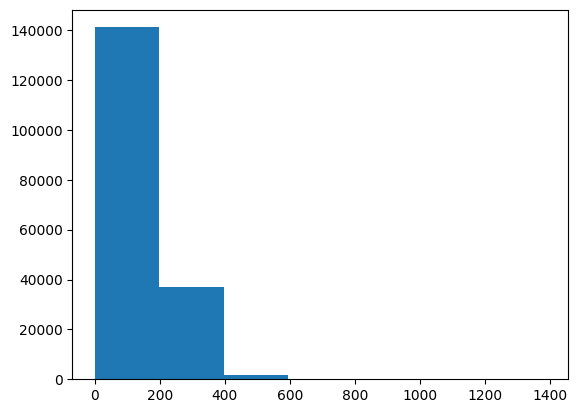

In [67]:
#check the distribution of our sequences at a characters
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [68]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Gell all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)+ 2 # add 2 for space and <OOV>(out of vocabulary)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                           output_sequence_length=output_seq_char_len,
                                           name="char_vectorizer",
                                          standardize="lower_and_strip_punctuation") #default option


In [71]:
# adapt it into training characters
char_vectorizer.adapt(train_chars)

In [72]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of differrent characters in character voacb: {len(char_vocab)}")
print(f"Most common characters:{char_vocab[:5]}")
print(f"Least common characters:{char_vocab[-5:]}")

Number of differrent characters in character voacb: 28
Most common characters:['', '[UNK]', 'e', 't', 'i']
Least common characters:['k', 'x', 'z', 'q', 'j']


In [73]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars{len(vectorized_chars[0])}")

Charified text:
 c u r r e n t   c l i n i c a l   t r i a l s   n c t @   ,   r e g i s t e r e d   @   a u g u s t   ,   @   .
Length of random_train_chars:46

Vectorized chars:
[[11 16  8  8  2  6  3 11 12  4  6  4 11  5 12  3  8  4  5 12  9  6 11  3
   8  2 18  4  9  3  2  8  2 10  5 16 18 16  9  3  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

### Creating a character level embedding

In [74]:
#creating a character embedding layer of 128
char_embedding = layers.Embedding(input_dim=len(char_vocab), # number of differrent characters in the vocabulary
                                  input_shape=(290,),
                                  output_dim=25, #size of the char embedding in the paper in figure.1
                                  mask_zero=True,
                                  name="char_embedding")

In [75]:
char_embedding(vectorized_chars)

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.01545772,  0.04268305, -0.00611949, ...,  0.02205583,
          0.0209976 ,  0.0248775 ],
        [ 0.0308365 ,  0.04949881, -0.00265776, ..., -0.01236559,
         -0.03669358,  0.00641351],
        [-0.00437421,  0.03624381, -0.02271487, ..., -0.02225437,
          0.02402002, -0.0428732 ],
        ...,
        [-0.0337973 ,  0.04066843, -0.04859759, ...,  0.02073414,
          0.03494772, -0.02020446],
        [-0.0337973 ,  0.04066843, -0.04859759, ...,  0.02073414,
          0.03494772, -0.02020446],
        [-0.0337973 ,  0.04066843, -0.04859759, ...,  0.02073414,
          0.03494772, -0.02020446]]], dtype=float32)>

In [76]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars after vectorization and embedding \n:{char_embed}\n")
print(f"Character embedding shape:{char_embed.shape}")

Charified text:
c u r r e n t   c l i n i c a l   t r i a l s   n c t @   ,   r e g i s t e r e d   @   a u g u s t   ,   @   .

Embedded chars after vectorization and embedding 
:[[[ 0.01545772  0.04268305 -0.00611949 ...  0.02205583  0.0209976
    0.0248775 ]
  [ 0.0308365   0.04949881 -0.00265776 ... -0.01236559 -0.03669358
    0.00641351]
  [-0.00437421  0.03624381 -0.02271487 ... -0.02225437  0.02402002
   -0.0428732 ]
  ...
  [-0.0337973   0.04066843 -0.04859759 ...  0.02073414  0.03494772
   -0.02020446]
  [-0.0337973   0.04066843 -0.04859759 ...  0.02073414  0.03494772
   -0.02020446]
  [-0.0337973   0.04066843 -0.04859759 ...  0.02073414  0.03494772
   -0.02020446]]]

Character embedding shape:(1, 290, 25)


In [77]:
len(random_train_chars)

111

### Building a Conv1D model to fit on character embeddings

In [78]:
#creating a model with character level embedding
inputs = layers.Input(shape=(1,), dtype="string")
#passing the inputs to char_vectorizer layer
x = char_vectorizer(inputs)
#passing the char_vector outputs to embedding layer
x = char_embedding(x)
#passing the char_embedded outputs to Conv1D layer
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(x)
#creating a pooling layer for condensing the outputs of Conv1D layer
x = layers.GlobalMaxPooling1D()(x)
# # creating a dense layer as an intermediary between pooling and output layer
# x = layers.Dense(64, activation="relu")(x)
#creating the output layer
outputs = layers.Dense(5, activation="softmax")(x)
#creating the model
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_char_embedding")

#getting the model summary
model_3.summary()

Model: "model_3_Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 5

In [79]:
# compiling model_3
model_3.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer="adam")


In [80]:
# create charlevel datasets
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
valid_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))

train_chars_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [81]:
#converting the dataset to prefetch batches
train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_chars_dataset = valid_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [82]:
# fitting the model_3, training and validating with 10% batches
model_3_history = model_3.fit(train_chars_dataset,
                              epochs=3,
                              validation_data=valid_chars_dataset,
                              steps_per_epoch=int(0.1 * len(train_chars_dataset)),
                              validation_steps=int(0.1 * len(valid_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2613 - accuracy: 0.4890 - val_loss: 1.0554 - val_accuracy: 0.5758
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0177 - accuracy: 0.5953 - val_loss: 0.9654 - val_accuracy: 0.6097
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9391 - accuracy: 0.6301 - val_loss: 0.8882 - val_accuracy: 0.6466


In [83]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(valid_chars_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 3s 3ms/step


array([[0.17608999, 0.5234106 , 0.05223542, 0.21675311, 0.03151087],
       [0.25079647, 0.5278719 , 0.02809933, 0.15779157, 0.03544072],
       [0.12206241, 0.40513137, 0.20871289, 0.19402002, 0.07007329],
       [0.01741482, 0.01521722, 0.8752643 , 0.01914666, 0.07295711],
       [0.01804096, 0.08801709, 0.63350767, 0.0351815 , 0.22525278]],
      dtype=float32)

In [84]:
# convert the prediction probabilities to class names
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 2, 2])>

In [85]:
#calculate the results for conv1d model chars only
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 64.71931682775056,
 'precision': 0.64007934129627,
 'recall': 0.6471931682775056,
 'f1': 0.6352240866412838}

In [86]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embedding  + characters embeddings(hybrid)

1. Create a token level embedding(similar to `model_1`
2. Create a character level embedding (similar to `model_3`
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure to Figure 1 and section 4.2
5. Construct a model which takes tokens and character-level sequences as input and produces sequence label probabilities


In [87]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-lstm shown in figure 1 of the paper accroding to paper is 50
char_model = tf.keras.Model(char_inputs, char_bi_lstm)               #bi directional lstm doubles the neurons

# 3. Create the concatenation layer to combine character and token embedding
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - adding in Droupout
combined_dropout = layers.Dropout(0.5)(token_char_concat) #drops 50% of the weights of the layer to prevent over fitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer, name="model_4_token_and_char_embeddings")


In [88]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

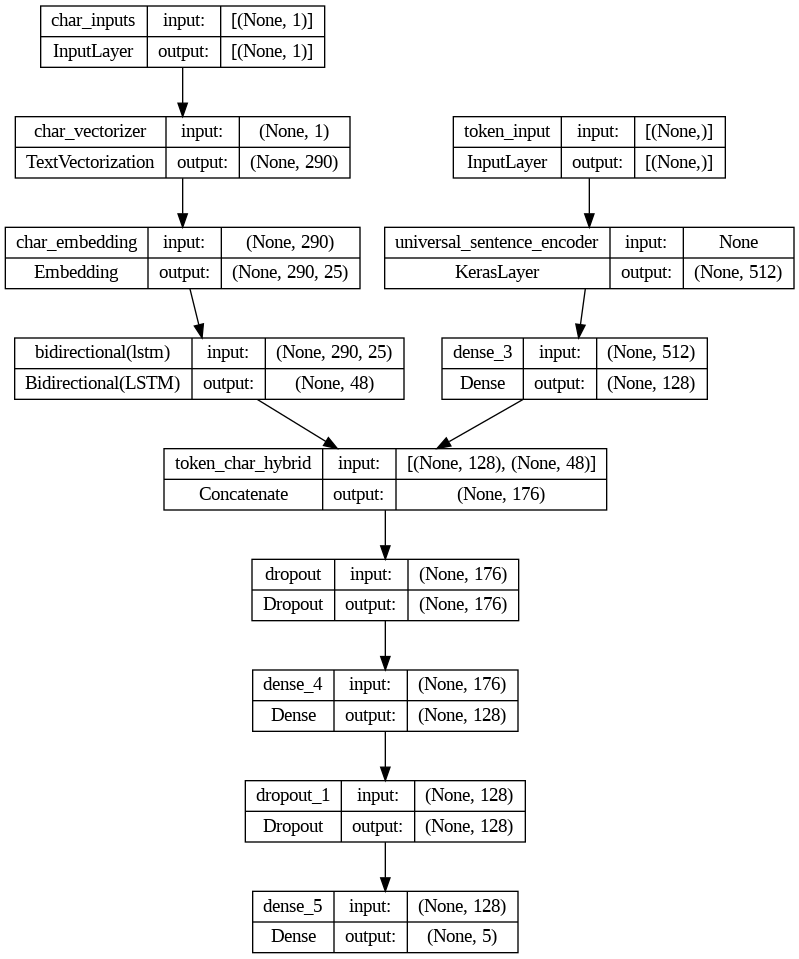

In [89]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [90]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam", #The paper uses SGD
                metrics=["accuracy"])

### Combining tokens and characters data into a tf.data.Dataset

In [91]:
# combining the char and token inputs into a batch for training test and validation
train_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)) #make data
train_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_token_labels)) #combine data and labels

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_token_labels))

#Prefetch and batch the data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [92]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

The order of the model inputs should be same as that of the batch

In [93]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 54ms/step - loss: 0.9893 - accuracy: 0.6043 - val_loss: 0.7824 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8063 - accuracy: 0.6896 - val_loss: 0.7188 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7807 - accuracy: 0.7040 - val_loss: 0.6929 - val_accuracy: 0.7404


In [94]:
# evaluating the model on full validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6987 - accuracy: 0.7340


[0.6986721158027649, 0.7340461015701294]

In [95]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:5]

945/945 [==============================] - 21s 20ms/step


array([[0.42670426, 0.35370135, 0.00485282, 0.20705833, 0.00768331],
       [0.31922972, 0.4914641 , 0.00362202, 0.1845237 , 0.00116055],
       [0.2783324 , 0.15257202, 0.03913621, 0.50008494, 0.02987442],
       [0.01187937, 0.02067492, 0.8333056 , 0.00622459, 0.12791558],
       [0.03147986, 0.09360209, 0.5951111 , 0.01475781, 0.26504916]],
      dtype=float32)

In [96]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [97]:
# Calculate model 4 results
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.40460744075202,
 'precision': 0.7359320104326638,
 'recall': 0.7340460744075202,
 'f1': 0.7315436174123483}

## Model 5: Transfer Learning with pretrained tokem embeddings + character embeddings + positional embedding

In [98]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **NOTE:** Any engineered features used to train a model need to be available at test time. In our case line numbers and total lines are available.

### Create Positional embeddings

In [99]:
# How many differrent line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

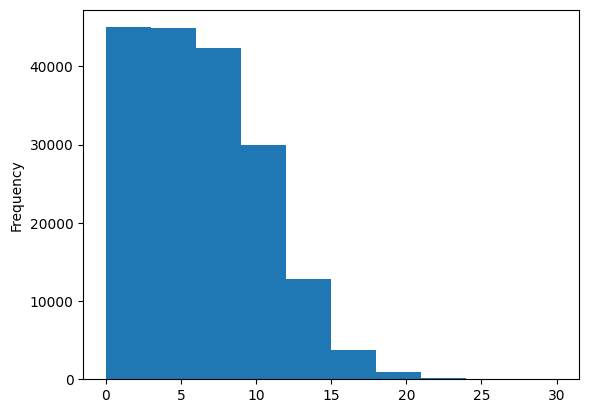

In [100]:
# check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [101]:
#checking the percentile value which represents most of the line numbers
np.percentile(train_df.line_number.to_numpy(), 98)

15.0

In [102]:
# Use tensorflow to create onehot encoded line number tensors
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [103]:
#doing the same for validation and test data
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

Now we have encoded our line numbers feature, let's do the same for total lines

In [104]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [105]:
#checking the most suitable value for depth of one-hot encoded labels
np.percentile(train_df.total_lines.to_numpy(), 98)

20.0

<Axes: ylabel='Frequency'>

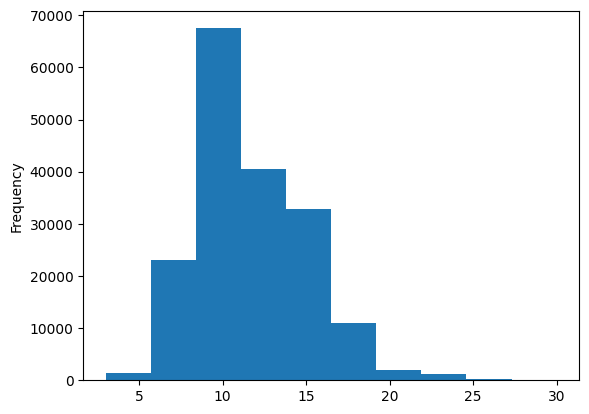

In [106]:
# Check the distribution of the data
train_df.total_lines.plot(kind="hist")

In [107]:
# Use Tensorflow to create one hot encoded tensors of our total_lines
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [108]:
#doing the same operation on validation and test data
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

### Building a tribrid model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_line" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the concatenated embeddings and predict the output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [109]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_embedding")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_5 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_5_tribrid_embedding")

> **NOTE:** Dropout layer has no output

In [110]:
# Get the summary of the tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                          

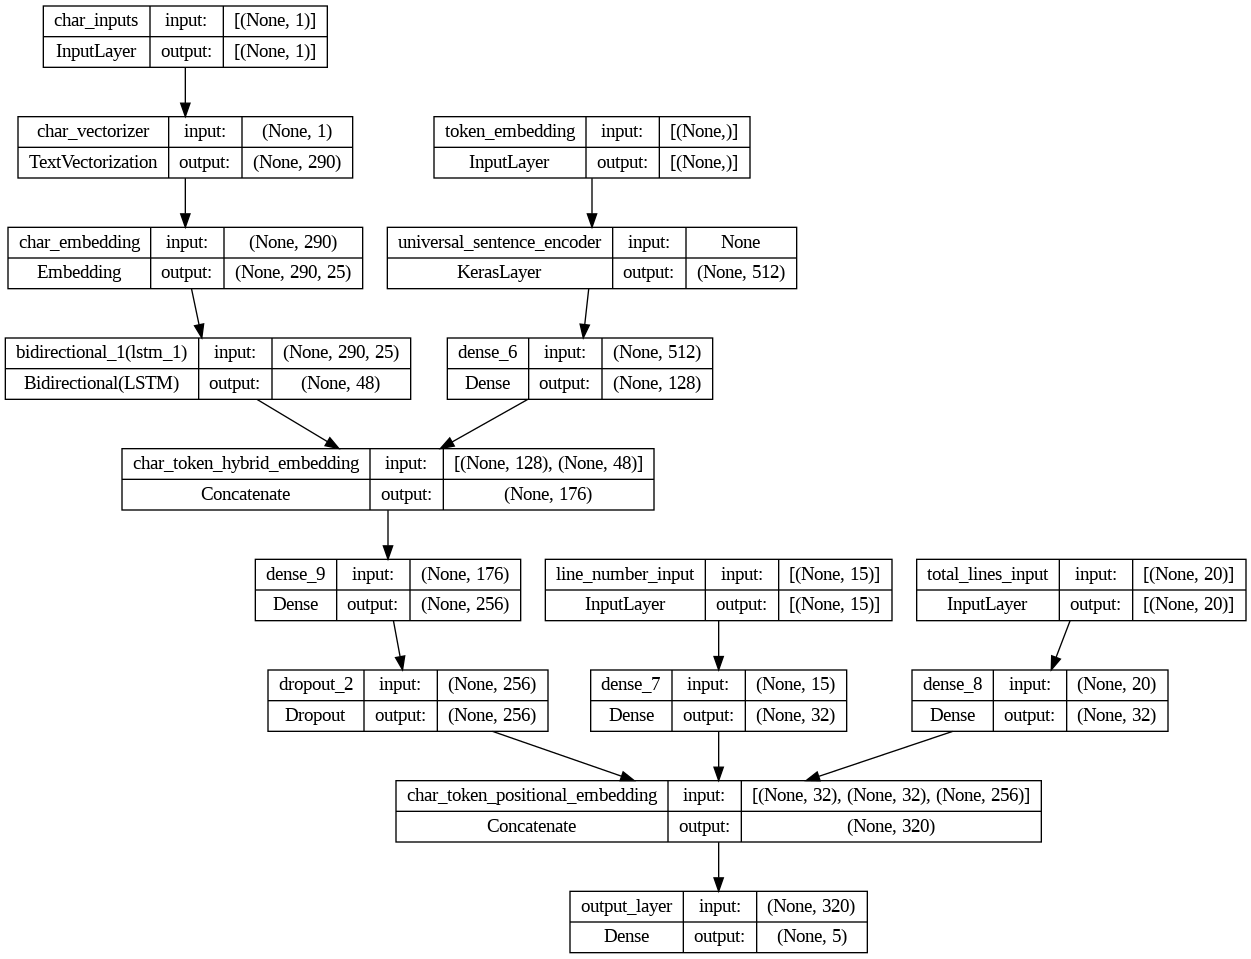

In [111]:
#Plotting the model architecture
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

**Label Smoothing**

If our model gets too confident on a single class i.e, the prediction probability is too high, it may stop learning altogether and stick to that particular class by completely ignoring other classes. What label smoothing does is that it will assign the prediction probabilities of the highest class to other classes. In turn hopefully improving the generalization ability of the model.

In [112]:
#compiling the model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps you to prevent overfitting
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [113]:
#creating training and validation data with all four kinds of data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [114]:
#check the input shapes
train_char_token_pos_dataset ,  val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting and evaluating the model


In [115]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                             )


Epoch 1/3
562/562 [==============================] - 40s 53ms/step - loss: 1.1044 - accuracy: 0.7166 - val_loss: 0.9788 - val_accuracy: 0.8125
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9670 - accuracy: 0.8156 - val_loss: 0.9454 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9480 - accuracy: 0.8253 - val_loss: 0.9370 - val_accuracy: 0.8351


In [116]:
#evaluating the model of the full validation dataset
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 22s 21ms/step


array([[0.5223872 , 0.10090435, 0.01007493, 0.34812227, 0.01851118],
       [0.5696148 , 0.07975596, 0.02717738, 0.3145677 , 0.00888414],
       [0.3000768 , 0.10371678, 0.10509627, 0.43063617, 0.06047406],
       [0.04390397, 0.05936709, 0.7023195 , 0.04003505, 0.15437435],
       [0.04709012, 0.03763434, 0.76233923, 0.0474597 , 0.10547655]],
      dtype=float32)

In [117]:
#converting the prediction probabilities to prediction labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [118]:
#calculating the model_5 results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.56282271944923,
 'precision': 0.8348989781693796,
 'recall': 0.8356282271944923,
 'f1': 0.8348137302442978}

In [119]:
model_4_results

{'accuracy': 73.40460744075202,
 'precision': 0.7359320104326638,
 'recall': 0.7340460744075202,
 'f1': 0.7315436174123483}

In [120]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

We can see a significant improvement in the results compared to the baseline model we created as well as the `model_4`.

## Model 6: Replicating `model_5` and training on full dataset

Our model 5 is the best performing model so far. Let's fit it on the complete train data and check the results.

In [125]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_embedding")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_6 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_6_tribrid_embedding")

In [126]:
#getting the model summary
model_6.summary()

Model: "model_6_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                          

In [127]:
#compiling the cloned_model_5
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps you to prevent overfitting
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [128]:
#training on full train dataset and validating on 10% of validation dataset for 5 epochs
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                             )

Epoch 1/5
5627/5627 [==============================] - 371s 65ms/step - loss: 0.9529 - accuracy: 0.8239 - val_loss: 0.9115 - val_accuracy: 0.8434
Epoch 2/5
5627/5627 [==============================] - 244s 43ms/step - loss: 0.9080 - accuracy: 0.8547 - val_loss: 0.9049 - val_accuracy: 0.8487
Epoch 3/5
5627/5627 [==============================] - 256s 46ms/step - loss: 0.8956 - accuracy: 0.8641 - val_loss: 0.8989 - val_accuracy: 0.8534
Epoch 4/5
5627/5627 [==============================] - 231s 41ms/step - loss: 0.8869 - accuracy: 0.8707 - val_loss: 0.8996 - val_accuracy: 0.8534
Epoch 5/5
5627/5627 [==============================] - 231s 41ms/step - loss: 0.8804 - accuracy: 0.8756 - val_loss: 0.8973 - val_accuracy: 0.8554


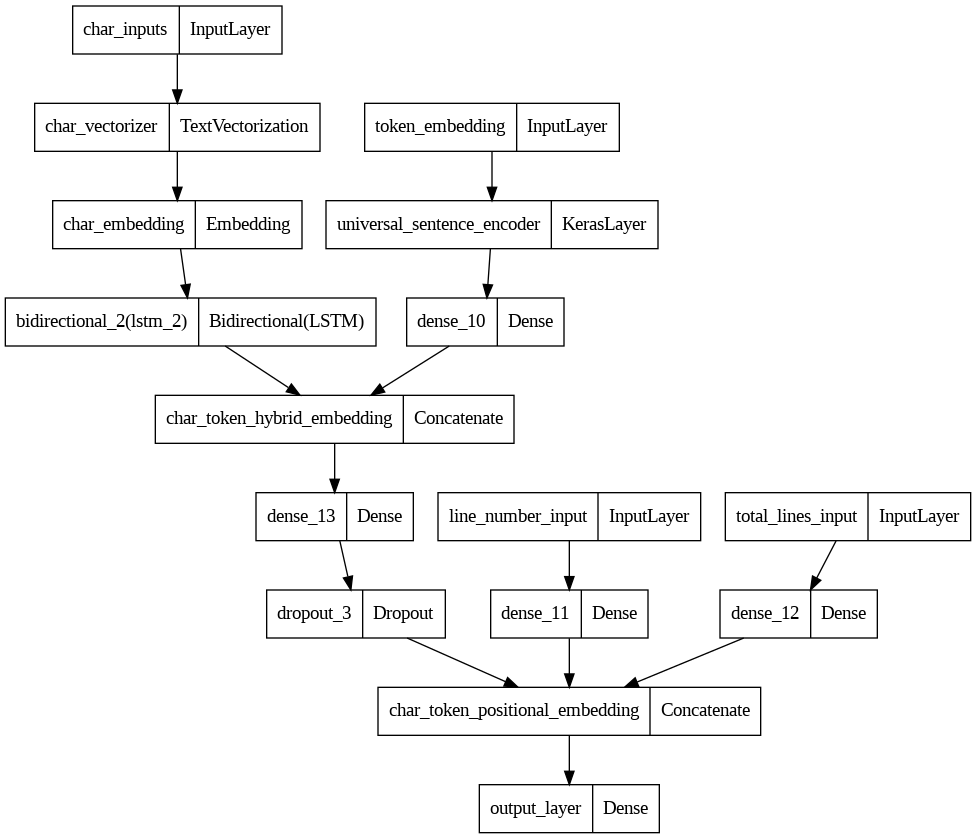

In [129]:
#visualising the model architecture
from keras.utils import plot_model
plot_model(model_6)

In [130]:
#evaluating the model on complete validation data
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [131]:
#evaluating the model on the complete validation dataset
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 85.70766582814777,
 'precision': 0.8585297408240312,
 'recall': 0.8570766582814776,
 'f1': 0.8543142773305533}

## Compare our model results

In [132]:
#combine model resuts into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":base_line_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results,
                                  "model_6_pos_char_token_embedding_full_data":model_6_results}).T

all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.793195,0.784723,0.787932,0.785398
model_2_pretrained_token_embedding,71.316033,0.713632,0.713160,0.710387
model_3_custom_char_embedding,64.719317,0.640079,0.647193,0.635224
model_4_hybrid_char_token_embedding,73.404607,0.735932,0.734046,0.731544
model_5_pos_char_token_embedding,83.562823,0.834899,0.835628,0.834814
model_6_pos_char_token_embedding_full_data,85.707666,0.858530,0.857077,0.854314


In [133]:
#cal

In [134]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results.accuracy / 100

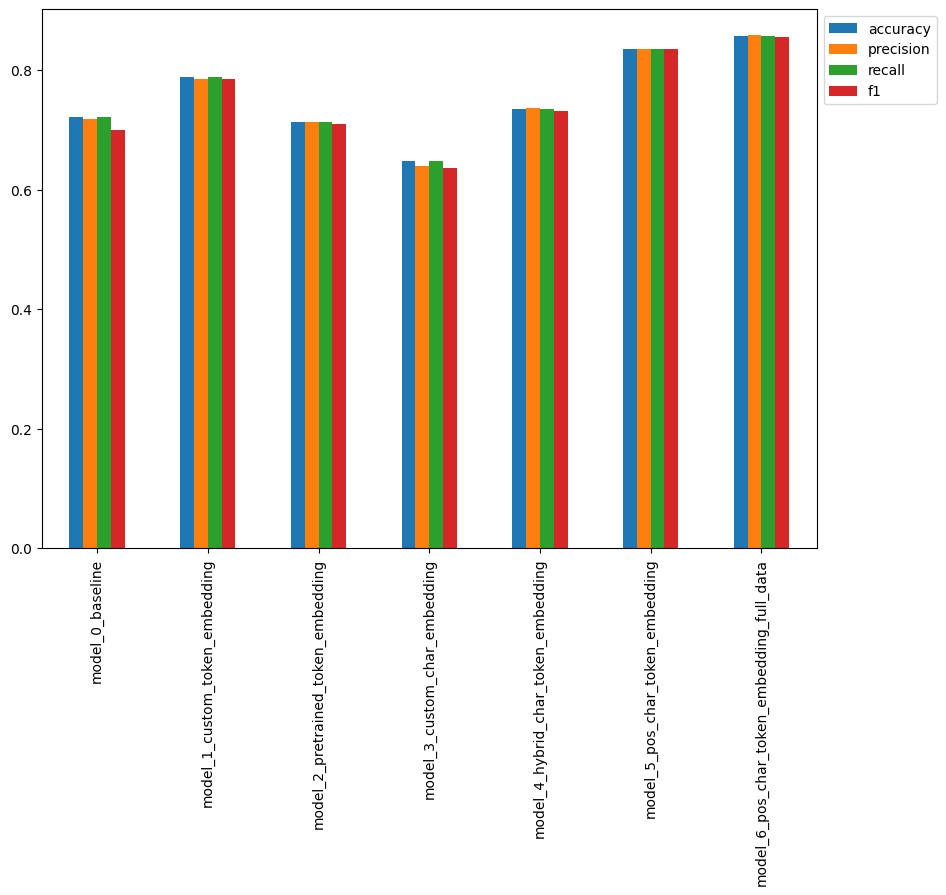

In [135]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

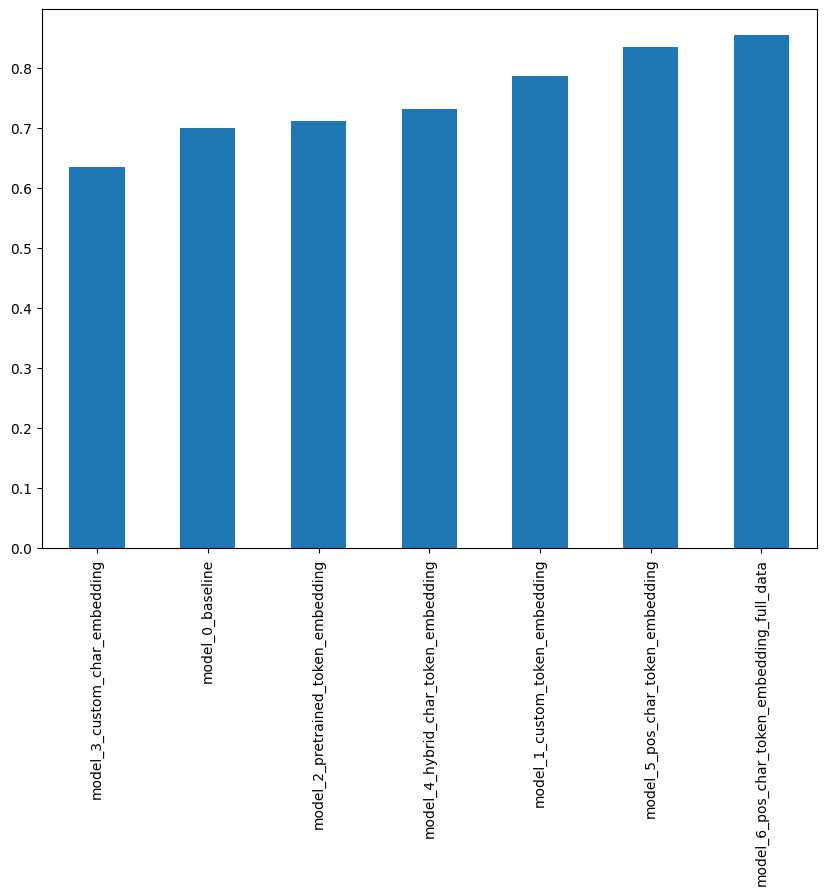

In [136]:
# Sort the model's results to score the models by f1-scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

In [137]:
#evaluating our model on full test data.
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,
    test_total_lines_one_hot,
    test_sentences,
    test_chars
))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [138]:
test_results = model_6.predict(test_char_token_pos_dataset)
test_preds = tf.argmax(test_results, axis=1)
model_6_result = calculate_results(test_labels_encoded, test_preds)
model_6_result

942/942 [==============================] - 20s 22ms/step


{'accuracy': 85.22979923676787,
 'precision': 0.8527605216069509,
 'recall': 0.8522979923676788,
 'f1': 0.8493569399373521}

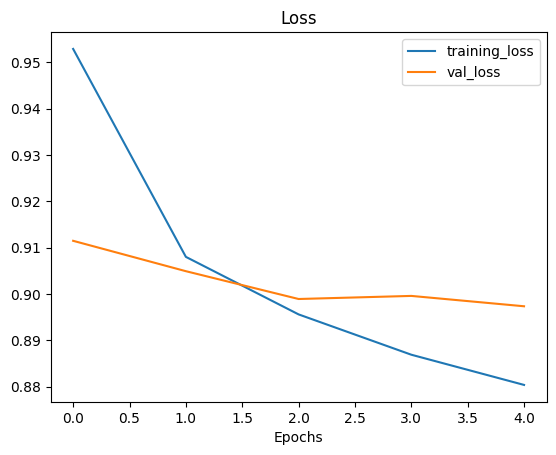

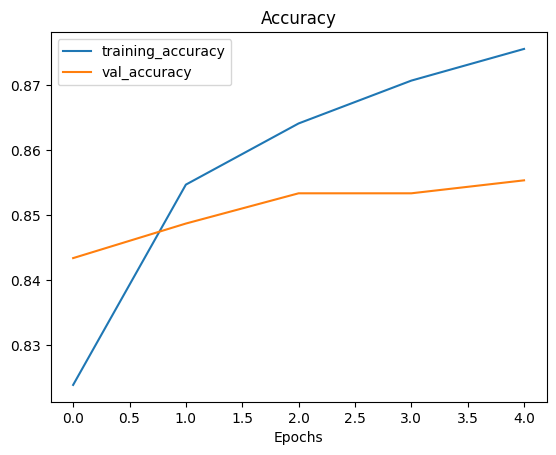

In [142]:
#plotting the loss curves of model_6
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_6)

## Saving the best performing model

We can save our best performing model which is `model_6`

In [139]:
!mkdir "skimlit_full_model"

In [141]:
model_6.save("skimlit_full_model/loaded_model_format")

In [143]:
#loadin the model and evaluating on the val_data
loaded_model = tf.keras.models.load_model("skimlit_full_model/loaded_model_format")
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 26s 25ms/step - loss: 0.8928 - accuracy: 0.8571


[0.8927565813064575, 0.8570766448974609]

In [144]:
#saving model in .keras format
model_6.save("skimlit_full_model/skimlit_full_model.keras")

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
